### Посчитаем tpr и fpr, построим матрицу ошибок и ROC кривую

In [196]:
import pandas as pd
import numpy as np

In [252]:
data = pd.read_csv('athletes.csv')
data.head(10)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
5,173071782,Aaron Royle,AUS,male,1/26/90,1.80,67.0,triathlon,0,0,0
6,266237702,Aaron Russell,USA,male,6/4/93,2.05,98.0,volleyball,0,0,1
7,382571888,Aaron Younger,AUS,male,9/25/91,1.93,100.0,aquatics,0,0,0
8,87689776,Aauri Lorena Bokesa,ESP,female,12/14/88,1.80,62.0,athletics,0,0,0
9,997877719,Ababel Yeshaneh,ETH,female,7/22/91,1.65,54.0,athletics,0,0,0


In [253]:
#с помощью info можем убедиться что в датасете есть пустые значения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
id             11538 non-null int64
name           11538 non-null object
nationality    11538 non-null object
sex            11538 non-null object
dob            11537 non-null object
height         11208 non-null float64
weight         10879 non-null float64
sport          11538 non-null object
gold           11538 non-null int64
silver         11538 non-null int64
bronze         11538 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Посмотрим много ли в наших признаках пустых значений

In [254]:
data[ data['height'].isna()].head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
12,258556239,Abbas Qali,IOA,male,10/11/92,NaN,NaN,aquatics,0,0,0
47,469953606,Abdoullah Bamoussa,ITA,male,6/8/86,NaN,NaN,athletics,0,0,0
50,325809293,Abdul Omar,GHA,male,10/3/93,NaN,NaN,boxing,0,0,0
52,262868423,Abdulaziz Alshatti,IOA,male,10/30/90,NaN,NaN,fencing,0,0,0
56,897549624,Abdullah Hel Baki,BAN,male,8/1/89,NaN,NaN,shooting,0,0,0


<AxesSubplot:>

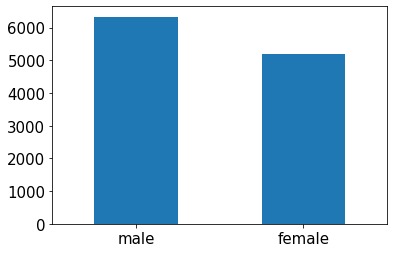

In [255]:
#поссмотрим соотношение male / female на графике
data.sex.value_counts().plot(kind="bar", rot=0)


<AxesSubplot:>

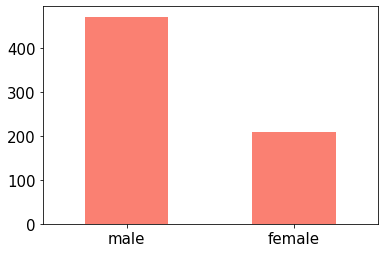

In [256]:
#построим такой же график только отобразим сколько пустых значений height или weight в разрезе male / female
data2 = data[ data['height'].isna() | data['weight'].isna()]
data2.sex.value_counts().plot(kind="bar", rot=0, color = '#FA8072')

In [257]:
#поссмотрим сколько пропусков в признаках
print('Для height пустых строк ' + str( len( data[ pd.isnull( data['height'] ) ] ) ))
print('Для weight пустых строк ' + str( len( data[ pd.isnull( data['weight'] ) ] ) ))
print('Для sport пустых строк ' + str( len( data[ pd.isnull( data['sport'] ) ] ) ))
print('Всего строк в наборе ' + str( len( data ) ))

Для height пустых строк 330
Для weight пустых строк 659
Для sport пустых строк 0
Всего строк в наборе 11538


In [258]:
# удалим строки с пропусками данных
data = data[ data['height'].isna() == 0 ]
data = data[ data['weight'].isna() == 0 ]

In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
id             10858 non-null int64
name           10858 non-null object
nationality    10858 non-null object
sex            10858 non-null object
dob            10858 non-null object
height         10858 non-null float64
weight         10858 non-null float64
sport          10858 non-null object
gold           10858 non-null int64
silver         10858 non-null int64
bronze         10858 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Строим модель

In [261]:
#удалим их датасета признак, который будем укадывать
X = data.drop(['sex'], axis=1)
X.head(5)

,id,name,nationality,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,11/26/90,1.81,71.0,cycling,0,0,0


In [262]:
# сам признак присвоим переменной y
y = data['sex']

In [263]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

In [265]:
#воспользуемся OneHotEncoder
ft = ohe.fit_transform(data[['nationality', 'sport']])

In [266]:
ft.toarray().shape

(10858, 227)

In [267]:
ohe.transform(data[['nationality', 'sport']])

<10858x227 sparse matrix of type '<class 'numpy.float64'>'
	with 21716 stored elements in Compressed Sparse Row format>

In [268]:
X = data[['height', 'weight', 'gold', 'silver', 'bronze']]
X.head(4)

,height,weight,gold,silver,bronze
0,1.72,64.0,0,0,0
1,1.68,56.0,0,0,0
2,1.98,79.0,0,0,1
3,1.83,80.0,0,0,0


In [270]:
#закодируем male / female 1 и 0
le.fit( data['sex'] )

LabelEncoder()

In [271]:
y = pd.Series( data = le.transform( data['sex'] ) )
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int64

In [272]:
#создаем модель логистической регресии
model = LogisticRegression()

In [273]:
#разобреьм наш датасет на тренировочные данные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=800)
X_train.head(5)

,height,weight,gold,silver,bronze
8449,1.90,90.0,0,0,0
1957,1.68,57.0,0,0,0
4300,1.74,57.0,1,0,0
8970,1.84,79.0,0,0,0
1428,1.95,90.0,0,0,0


In [274]:
#обучим нашу модеь на тренировочных данных
model.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [275]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

### Построение матрицы ошибок

Confusion matrix, without normalization
[[ 949  312]
 [ 313 1141]]


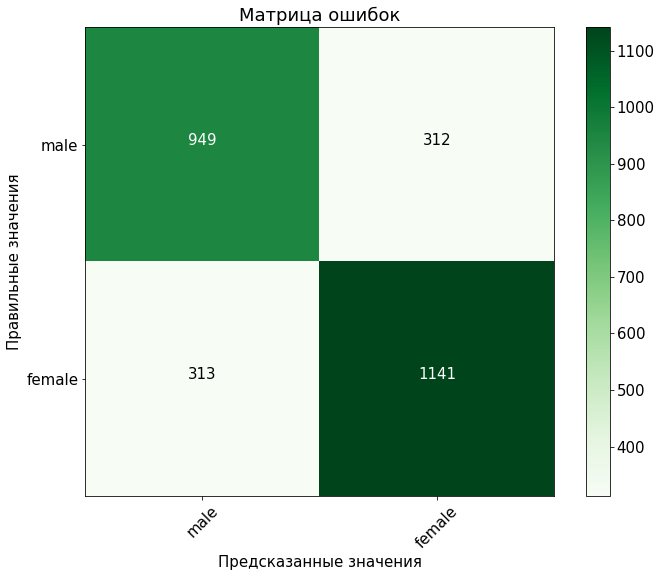

In [276]:
#функция построения матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j], 
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Правильные значения')
    plt.xlabel('Предсказанные значения')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=data['sex'].unique(),
                      title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()

In [278]:
# из полученной матрицы ошибок мы можем взять все показатели tp fp fn tn
tp = conf[0][0]
fp = conf[0][1]
fn = conf[1][0]
tn = conf[1][1]

In [279]:
print("TP - " + str(tp))
print("FP - " + str(fp))
print("FN - " + str(fn))
print("TN - " + str(tn))

TP - 949
FP - 312
FN - 313
TN - 1141


In [284]:
#Посчитаем TPR и FPR на ранее полученных данных
print("TPR - " + str(tp / (tp + fn)))
print("FPR - " + str(fp / (fp + tn)))

TPR - 0.7519809825673535
FPR - 0.21472814865794906


In [286]:
# предскажем вероятность
predictions = model.predict_proba(X_test)[:, 1]

In [287]:
predictions

array([0.26301139, 0.11093211, 0.71877818, ..., 0.56224904, 0.59496419,
       0.19728192])

### Построение ROC кривой

In [288]:
fpr, tpr, thres = roc_curve( y_test, predictions)

In [127]:
from matplotlib import pyplot as plt

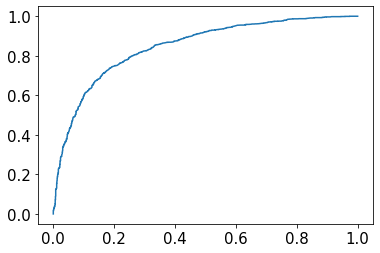

In [289]:
plt.plot( fpr, tpr )

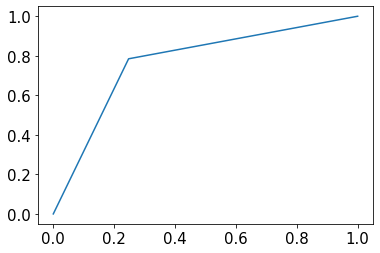

In [290]:
fpr, tpr, thres = roc_curve( y_test, model.predict(X_test))
plt.plot( fpr, tpr )

In [134]:
from sklearn.metrics import roc_auc_score

In [135]:
roc_auc_score(y_test, predictions)

0.8518168373151307

In [136]:
roc_auc_score(y_test, model.predict(X_test))

0.7733356086461888